# Sleep ECoG Processing 
##### my attempts to do this all in Python...

- Frequency band power analysis between sleep + wake data sets
- subject a0f66459, day 6

## Outline
- options
- load raw data
- separate out grid channels (1-64) and sleep vs. wake (1 hour each)
- visualize all 64 channels
- id channel 37 as bad - remove from set
- reshape into 20 trials 
- get power bands
- t-test, bar plot
- classify sleep vs. wake


In [15]:
# import things that might be useful to me
%matplotlib inline
import numpy as np
import pandas as pd 
import time
from scipy import signal
import matplotlib.pyplot as plt
import scipy as sp
import h5py
import math

# custom functions here
import filtering_tools as filt

print('Pandas version:',pd.__version__)

Pandas version: 0.24.2


In [2]:
# options
plot_on = 1;
save_on = 0;

In [34]:
# load raw data

filename = r"C:\Users\sunh20\Documents\Projects\SleepClass_SS\ecog\processed_a0f66459_6.h5"
fin = h5py.File(filename, "r")
print(list(fin.keys()))
ecog_d = fin.get('dataset')
fs = int(fin.get('f_sample')[()])
chan_label = fin.get('chanLabels')


['Kurt_channels', 'SD_channels', 'allChanArtifactInds', 'chanLabels', 'dataset', 'f_sample', 'goodChanInds', 'standardizeDenoms', 'start_timestamp', 'start_timestamp_nw']


AttributeError: 'Dataset' object has no attribute 'transpose'

In [4]:
# data information
print('These are your variables:')
print('ecog_d:', ecog_d.shape, ecog_d.dtype)
print('fs:',fs)
print('chan_label:', chan_label.shape, chan_label.dtype)
print()
print(chan_label[()])

These are your variables:
ecog_d: (129, 42764078) float32
fs: 500
chan_label: () object

['Event', 'GRID1', 'GRID2', 'GRID3', 'GRID4', 'GRID5', 'GRID6', 'GRID7', 'GRID8', 'GRID9', 'GRID10', 'GRID11', 'GRID12', 'GRID13', 'GRID14', 'GRID15', 'GRID16', 'GRID17', 'GRID18', 'GRID19', 'GRID20', 'GRID21', 'GRID22', 'GRID23', 'GRID24', 'GRID25', 'GRID26', 'GRID27', 'GRID28', 'GRID29', 'GRID30', 'GRID31', 'GRID32', 'GRID33', 'GRID34', 'GRID35', 'GRID36', 'GRID37', 'GRID38', 'GRID39', 'GRID40', 'GRID41', 'GRID42', 'GRID43', 'GRID44', 'GRID45', 'GRID46', 'GRID47', 'GRID48', 'GRID49', 'GRID50', 'GRID51', 'GRID52', 'GRID53', 'GRID54', 'GRID55', 'GRID56', 'GRID57', 'GRID58', 'GRID59', 'GRID60', 'GRID61', 'GRID62', 'GRID63', 'GRID64', 'LID1', 'LID2', 'LID3', 'LID4', 'LID5', 'LID6', 'LID7', 'LID8', 'LAT1', 'LAT2', 'LAT3', 'LAT4', 'LAT5', 'LAT6', 'LMT1', 'LMT2', 'LMT3', 'LMT4', 'LPT1', 'LPT2', 'LPT3', 'LPT4', 'LPT5', 'LPT6', 'LTO1', 'LTO2', 'LTO3', 'LTO4', 'LTO5', 'LTO6', 'EOGL', 'EOGR', 'ECGL', 'ECGR'

In [35]:
# separate out grid data
# first index = event data (ignore)
ECOG_data = ecog_d[0:65,].transpose();
print('ECOG_data:',ECOG_data.shape)


ECOG_data: (42764078, 65)


In [77]:
# get sleep and wake times
t_start = 8*60*60 + 13*60 + 24 # seconds

# get sleep and wake times
t_wake = 8*60*60 + 59*60 + 36
t_sleep = 8*60*60 + 16*60*60 + 59*60 + 36

# adjust to get start indices for wake + sleep
t_wake = (int)((t_wake - t_start)*fs)
t_sleep = (int)((t_sleep - t_start)*fs)
t = np.arange(0,60*60,1/fs);

data_wake = ECOG_data[t_wake:t_wake+fs*math.ceil(t[-1]),]
data_sleep = ECOG_data[t_sleep:t_sleep+fs*math.ceil(t[-1]),]

print('t:',t.shape)
print('data_wake:', data_wake.shape)
print('data_sleep:', data_sleep.shape)

t: (1800000,)
data_wake: (1800000, 65)
data_sleep: (1800000, 65)


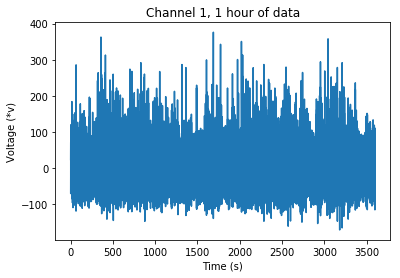

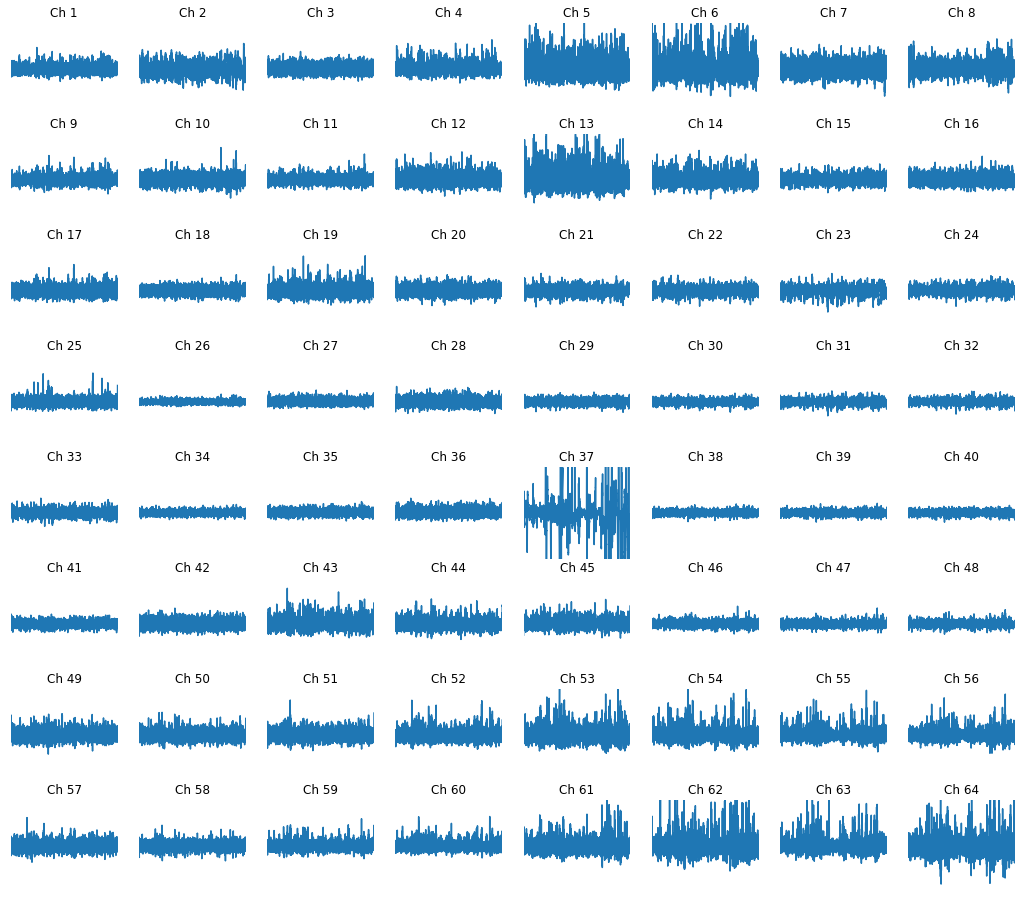

In [37]:
# visualize 64 channels
if plot_on:
    plt.figure
    plt.plot(t,data_wake[:,1])
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (*v)')
    plt.title('Channel 1, 1 hour of data')

    plt.figure(figsize=(18,16))
    for ch in range(0,64):
        plt.subplot(8,8,ch+1)
        plt.box(False)
        plt.plot(t[0:90000],data_wake[0:90000,ch+1])
        plt.axis([0, 60, -400, 400])
        plt.title('Ch ' + str(ch+1))
        plt.xticks(ticks=[], labels=[])
        plt.yticks(ticks=[], labels=[])
    

In [78]:
# remove ch 37 + make list of channels
chan = np.arange(0,65)
chan = np.delete(chan,37)

data_wake = np.delete(data_wake,37,1)
data_sleep = np.delete(data_sleep,37,1)

print('Removed channel 37')
print('data_wake:', data_wake.shape)
print('data_sleep:', data_sleep.shape)

Removed channel 37
data_wake: (1800000, 64)
data_sleep: (1800000, 64)


In [76]:
# reshape into 20 trials - 3 min long trials
num_trials = 20
trial_length = fs*60*3

data_wake_split = data_wake
data_wake_split = np.reshape(data_wake_split,[num_trials,trial_length,64])
print('data_wake_split:',data_wake_split.shape)

data_sleep_split = data_sleep
data_sleep_split = np.reshape(data_sleep_split,[num_trials,trial_length,64])
print('data_sleep_split:',data_sleep_split.shape)

# first 10 items in ch 1
print(data_sleep_split[0,0:10,1] == data_sleep[0:10,1])

# item 90001 in ch 1
print(data_sleep_split[1,1,1] == data_sleep[90001,1])

# item 180001 in ch 3
print(data_sleep_split[2,1,3] == data_sleep[180001,3])

data_wake_split: (20, 90000, 64)
data_sleep_split: (20, 90000, 64)
[ True  True  True  True  True  True  True  True  True  True]
True
True


In [ ]:
# get power bands

# for each trial 1-20
    # for each of the frequency bands

In [57]:
# practice indexing lol
a = np.array([[1, 2, 3, 0],[4, 5, 6, 0],[7, 8, 9, 0],[10, 11, 12, 0]])
print(a)

print(a[0,0])
print(a[2,2])

print(a[0:1,0])
print(a[0:2,0])

a = a.reshape([2, 2, 4])
print(a)
print(a[0,0,0])
print(a[0,0,1])

[[ 1  2  3  0]
 [ 4  5  6  0]
 [ 7  8  9  0]
 [10 11 12  0]]
1
9
[1]
[1 4]
[[[ 1  2  3  0]
  [ 4  5  6  0]]

 [[ 7  8  9  0]
  [10 11 12  0]]]
1
2


In [10]:
# some useful code i want to keep

# my tic toc
# start_time = time.time()
#print("--- %s seconds elapsed ---" % (time.time() - start_time))

# whos - will tell me all the variables in current workspace